# Dependencies and files

## Install dependencies

## Imports

In [1]:
import warnings
import json
import requests
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import scanpy as sc
import os
from tqdm.notebook import tqdm

warnings.simplefilter(action='ignore', category=FutureWarning)

# Global variables

In [2]:
de_dir_path = './results/'

In [3]:
os.listdir(de_dir_path)

['anova_mamm_mean.csv',
 'cluster_spectr_anova_mean_6.csv',
 'cluster_spectr_anova_mean_7.csv',
 'cluster_spectr_anova_mean_8.csv',
 'cluster_spectr_anova_mean_9.csv',
 'pb_mammals_filtered.h5ad',
 'pb_mammals_samplenorm_mean.h5ad',
 'ttest_mamm_mean.csv']

In [4]:
adata_pb_norm = sc.read_h5ad(de_dir_path + 'pb_mammals_samplenorm_mean.h5ad')
adata_pb_norm

AnnData object with n_obs × n_vars = 89 × 9208
    obs: 'layer', 'sample_id', 'psbulk_n_cells', 'psbulk_counts', 'condition', 'lib_size', 'log_lib_size'
    var: 'feature_types', 'mt', 'hb', 'ribo'
    uns: 'log1p', 'pca'
    obsm: 'X_pca'
    varm: 'PCs'
    layers: 'psbulk_props'

In [5]:
background_genes = adata_pb_norm.var_names.tolist()
len(background_genes)

9208

In [6]:
def p_val_group(value):
    if value >= 0.05:
        return 'No significance'
    elif  0.01 <= value < 0.05:
        return 'p < 0.05'
    elif  0.001 <= value < 0.01:
        return 'p < 0.01'
    else:
        return 'p < 0.001'

In [7]:
color_discrete_map = {'No significance': 'darkblue',
                      'p < 0.05': 'purple',
                      'p < 0.01': 'darkorange',
                      'p < 0.001': 'yellow'}

In [8]:
class GeneCluster:
    def __init__(self, genes, descr, label, background_genes, **kwargs):
        self.label = label
        self.genes = genes
        self.descr = descr
        self.background_genes = background_genes
        self.userlist_id = self._get_userlist_id()
        self.background_id = self._get_background_id()
        self.enrichment_res = dict()

    
    def _get_userlist_id(self):
        base_url = "https://maayanlab.cloud/speedrichr"

        description = "sample gene set with background"

        res = requests.post(
            base_url+'/api/addList',
            files=dict(
              list=(None, '\n'.join(self.genes)),
              description=(None, description),
            )
          )
        if res.ok:
            userlist_response = res.json()
        return userlist_response['userListId']
    
    def _get_background_id(self):
        base_url = "https://maayanlab.cloud/speedrichr"

        res = requests.post(
            base_url+'/api/addbackground',
            data=dict(background='\n'.join(self.background_genes))
        )

        if res.ok:
            background_response = res.json()
        return background_response['backgroundid']

    def enrich(self, gene_set_library):
        # get enrichment results
        base_url = "https://maayanlab.cloud/speedrichr"

        res = requests.post(
                base_url+'/api/backgroundenrich',
                data=dict(
                userListId=self.userlist_id,
                backgroundid=self.background_id,
                backgroundType=gene_set_library,
                )
            )
        if res.ok:
            data = res.json()
        # convert results to df
        columns = ['Rank', 'Term', 'p-val', 'Z-score', 'Combined score', 'Overlapping genes', 'Adjusted P-value', 'Old p-value', 'Old adjusted p-value']
        results = pd.DataFrame(data[gene_set_library], columns=columns)
        # preprocess df
        results.Term = results.Term.astype(str)
        results['num_overlap_genes'] = results['Overlapping genes'].apply(lambda x: len(x))
        results['neg_log10(p_adj)'] = - np.log10(results['Adjusted P-value'])
        results['cluster_label'] = self.label
        # save to enrichment_res
        self.enrichment_res[gene_set_library] = results

    @staticmethod
    def enrich_geneclusters(geneclusters, gene_set_library):
        for gc in geneclusters:
            gc.enrich(gene_set_library)

# GSA (6 clusters)

In [9]:
n_clusters = 6
cluster_spectr = pd.read_csv(de_dir_path + f'cluster_spectr_anova_mean_{n_clusters}.csv', index_col=0)
cluster_spectr.columns = ['label']
cluster_spectr.head()

,label
HPS4,0
SLC29A4,0
MED6,0
UBE2G1,0
COPS6,0


In [10]:
import time
gene_clust = list()

for label in tqdm(range(n_clusters)):
    genes = cluster_spectr[cluster_spectr.label == label].index.tolist()
    descr = f'Genes for spectral clustering ({n_clusters} clusters) of human-specific genes. Cluster label: {label}'
    gene_clust.append(GeneCluster(genes, descr, label, background_genes))
    time.sleep(1)

  0%|          | 0/6 [00:00<?, ?it/s]

## GO_Biological_Process_2021

In [11]:
GeneCluster.enrich_geneclusters(gene_clust, 'GO_Biological_Process_2021')

In [12]:
enrich_res = pd.concat([gc.enrichment_res['GO_Biological_Process_2021'] for gc in gene_clust])
enrich_res = enrich_res.set_index(['Term'])
enrich_res.head()

,Rank,p-val,Z-score,Combined score,Overlapping genes,Adjusted P-value,Old p-value,Old adjusted p-value,num_overlap_genes,neg_log10(p_adj),cluster_label
Term,,,,,,,,,,,
aerobic electron transport chain (GO:0019646),1,9.721249e-10,7.056311,146.429294,"[COX8A, NDUFB9, NDUFA8, COX7B, NDUFB8, NDUFB10...",0.000002,0,0,21,5.630910,0
mitochondrial ATP synthesis coupled electron transport (GO:0042775),2,1.476379e-09,6.834983,138.980310,"[COX8A, NDUFB9, NDUFA8, COX7B, NDUFB8, NDUFB10...",0.000002,0,0,21,5.630910,0
mitochondrial respiratory chain complex I assembly (GO:0032981),3,3.738415e-07,5.683903,84.118547,"[NDUFB9, NDUFA8, NDUFB8, COA1, DMAC1, NDUFB10,...",0.000296,0,0,17,3.528450,0
NADH dehydrogenase complex assembly (GO:0010257),4,3.738415e-07,5.683903,84.118547,"[NDUFB9, NDUFA8, NDUFB8, COA1, DMAC1, NDUFB10,...",0.000296,0,0,17,3.528450,0
"mitochondrial electron transport, cytochrome c to oxygen (GO:0006123)",5,3.374341e-06,16.451534,207.277982,"[COX8A, COX7B, NDUFA4, COX4I1, COX5B, COX5A, C...",0.002139,0,0,8,2.669859,0


In [13]:
terms = enrich_res[enrich_res.Rank < 5].index.unique()
terms.size

22

In [14]:
from pandas.api.types import CategoricalDtype
enrich_res_plot = enrich_res.loc[terms].copy()
cat_type = CategoricalDtype(categories=['No significance', 'p < 0.05', 'p < 0.01', 'p < 0.001'], ordered=True)
enrich_res_plot['p-value'] = enrich_res_plot['p-val'].apply(p_val_group).astype(cat_type)

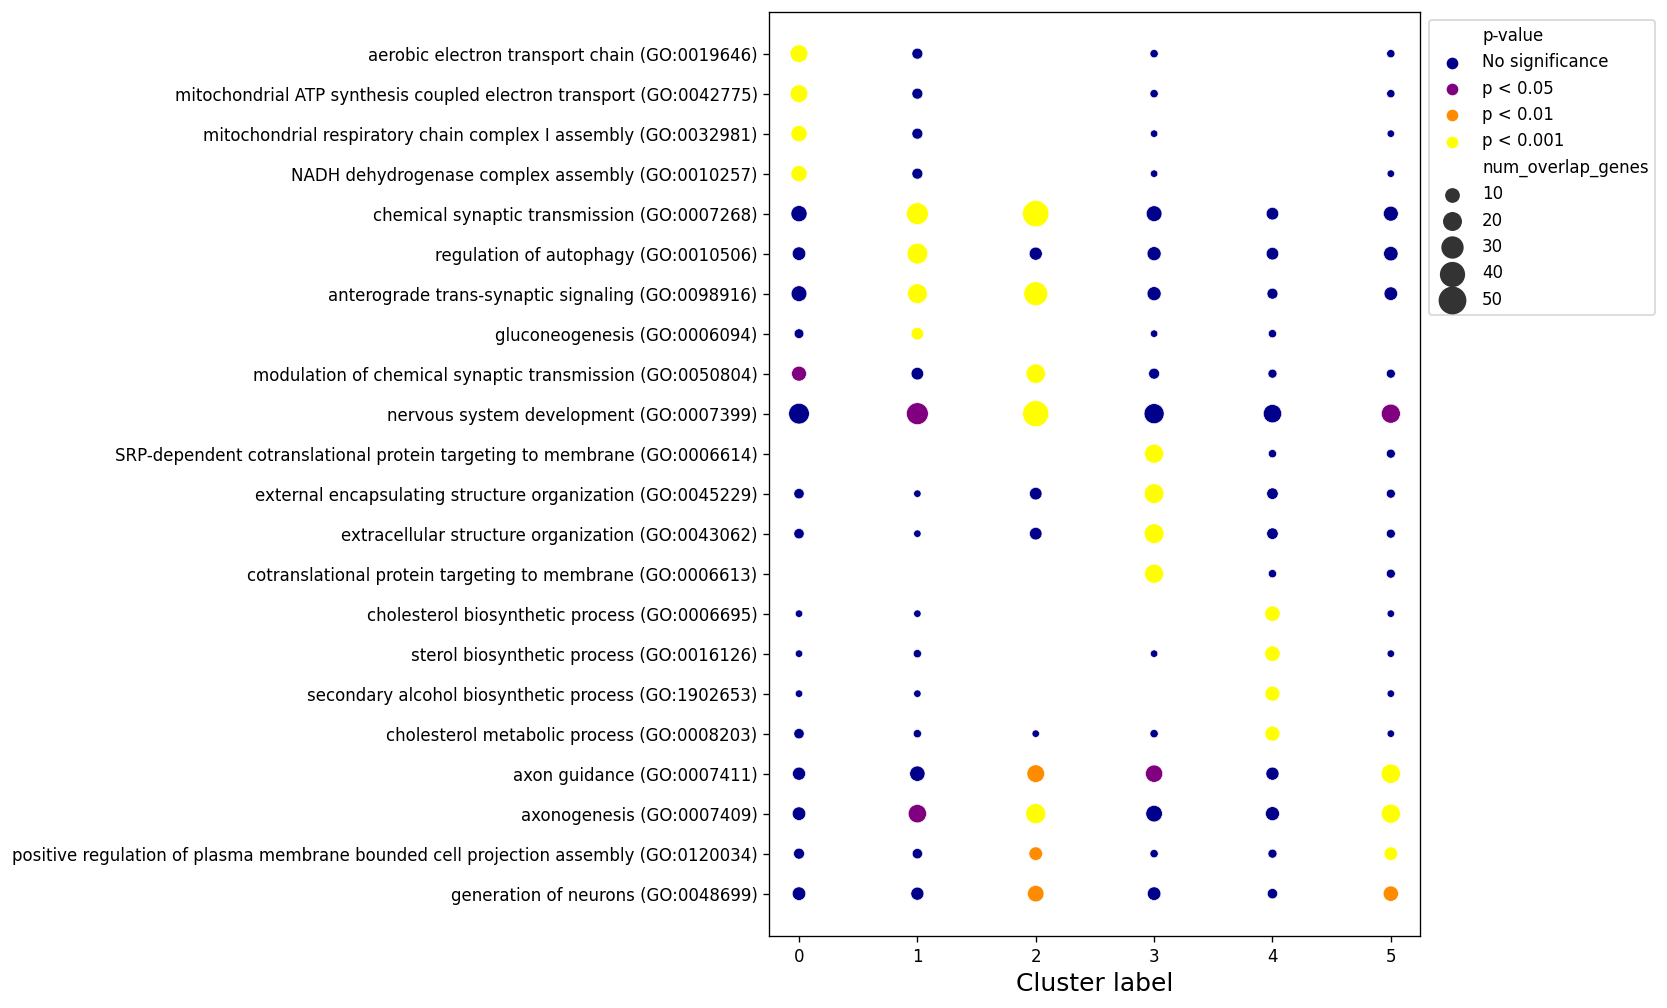

In [15]:
fig = plt.figure(figsize=(7, 10), dpi=120)

ax = sns.scatterplot(
    data=enrich_res_plot.reset_index(),
    x='cluster_label',
    y='Term',
    size='num_overlap_genes',
    sizes=(20, 250),
    hue='p-value',
    palette=color_discrete_map
)

ax.tick_params(labelsize=10)
ax.legend(fontsize=15)
ax.set_xlabel("Cluster label",fontsize=15)
ax.set_ylabel("", fontsize=10)

sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

## Azimuth Cell Types 2021


In [16]:
GeneCluster.enrich_geneclusters(gene_clust, 'Azimuth_Cell_Types_2021')

In [17]:
enrich_res = pd.concat([gc.enrichment_res['Azimuth_Cell_Types_2021'] for gc in gene_clust])
enrich_res = enrich_res.set_index(['Term'])
enrich_res.head()

,Rank,p-val,Z-score,Combined score,Overlapping genes,Adjusted P-value,Old p-value,Old adjusted p-value,num_overlap_genes,neg_log10(p_adj),cluster_label
Term,,,,,,,,,,,
RORB+ LAMA4+ Layer 3-5 Glutamatergic Neuron CL0000679,1,0.000294,40.947497,332.926810,"[PLCH1, RORA, IL1RAP, RORB]",0.038272,0,0,4,1.417122,0
Vip+ GABAergic Neuron 2 CL0000617,2,0.011578,10.221951,45.576094,"[CALB2, GRIN2A, NRXN1]",0.360168,0,0,3,0.443495,0
Goblet CL0000160,3,0.011578,10.221951,45.576094,"[LCN2, TXN, COX5A]",0.360168,0,0,3,0.443495,0
SST+ FAM20A+ Layer 1-3 GABAergic Neuron CL0000617,4,0.018927,7.665549,30.410437,"[KIRREL3, FAM20A, TAC1]",0.360168,0,0,3,0.443495,0
Delta Islet Cell CL0000173,5,0.018927,7.665549,30.410437,"[RBP4, RGS2, SEC11C]",0.360168,0,0,3,0.443495,0


In [18]:
terms = enrich_res[enrich_res.Rank < 5].index.unique()
terms.size

24

In [19]:
from pandas.api.types import CategoricalDtype
enrich_res_plot = enrich_res.loc[terms].copy()
cat_type = CategoricalDtype(categories=['No significance', 'p < 0.05', 'p < 0.01', 'p < 0.001'], ordered=True)
enrich_res_plot['p-value'] = enrich_res_plot['p-val'].apply(p_val_group).astype(cat_type)

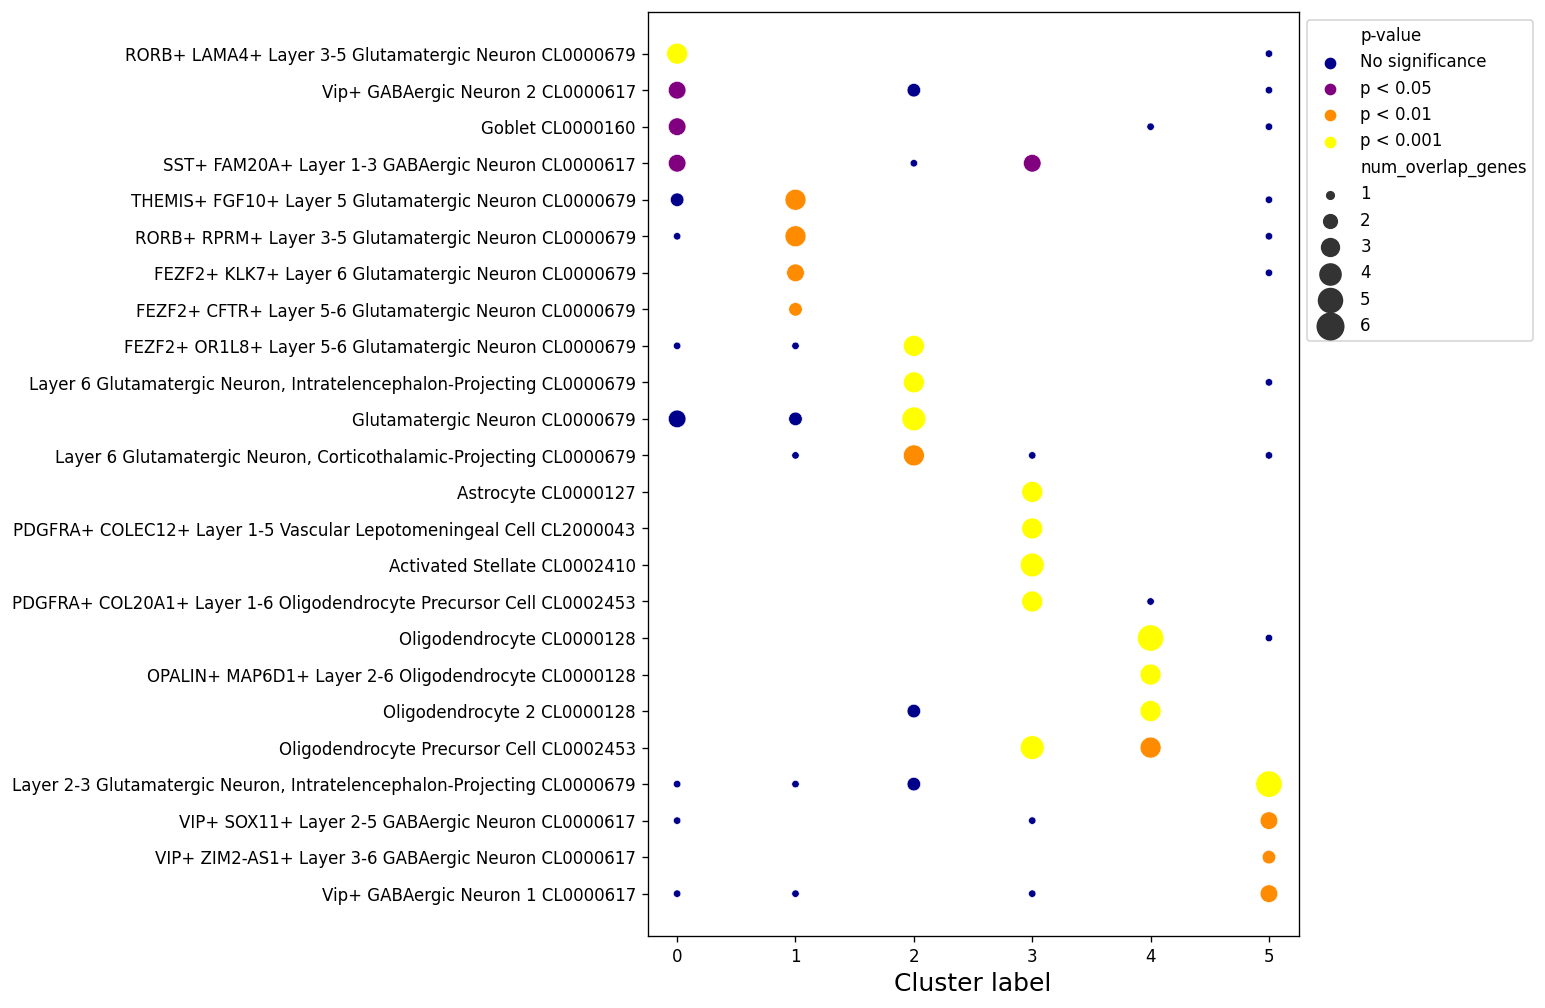

In [20]:
fig = plt.figure(figsize=(7, 10), dpi=120)

ax = sns.scatterplot(
    data=enrich_res_plot.reset_index(),
    x='cluster_label',
    y='Term',
    size='num_overlap_genes',
    sizes=(20, 250),
    hue='p-value',
    palette=color_discrete_map
)

ax.tick_params(labelsize=10)
ax.legend(fontsize=15)
ax.set_xlabel("Cluster label",fontsize=15)
ax.set_ylabel("", fontsize=10)

sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

## MGI_Mammalian_Phenotype_Level_4_2021

In [21]:
GeneCluster.enrich_geneclusters(gene_clust, 'MGI_Mammalian_Phenotype_Level_4_2021')

In [22]:
enrich_res = pd.concat([gc.enrichment_res['MGI_Mammalian_Phenotype_Level_4_2021'] for gc in gene_clust])
enrich_res = enrich_res.set_index(['Term'])
enrich_res.head()

,Rank,p-val,Z-score,Combined score,Overlapping genes,Adjusted P-value,Old p-value,Old adjusted p-value,num_overlap_genes,neg_log10(p_adj),cluster_label
Term,,,,,,,,,,,
abnormal spatial learning MP:0001463,1,0.000019,2.920222,31.809108,"[RTN4R, B4GALT2, NRN1, RGS14, PDE1B, FMR1, ARX...",0.045758,0,0,25,1.339529,0
abnormal sperm head morphology MP:0009230,2,0.000505,4.868356,36.951410,"[BSCL2, GSK3A, CLIP1, GPX4, EGR4, UBE2B, SPATC...",0.419193,0,0,9,0.377586,0
abnormal circadian behavior MP:0020467,3,0.000857,5.985600,42.270221,"[RAI1, CADPS2, FMR1, NMU, DTNBP1, ARNTL, NR2F6]",0.419193,0,0,7,0.377586,0
increased bone volume MP:0010875,4,0.000969,10.244499,71.086995,"[CEBPB, CRY2, SNX10, HIVEP3, FOS]",0.419193,0,0,5,0.377586,0
abnormal nervous system electrophysiology MP:0002272,5,0.001095,2.944023,20.069415,"[KCNC2, GAD1, ARX, GRIK1, KCNAB1, KCNAB2, CALB...",0.419193,0,0,14,0.377586,0


In [23]:
terms = enrich_res[enrich_res.Rank < 5].index.unique()
terms.size

24

In [24]:
from pandas.api.types import CategoricalDtype
enrich_res_plot = enrich_res.loc[terms].copy()
cat_type = CategoricalDtype(categories=['No significance', 'p < 0.05', 'p < 0.01', 'p < 0.001'], ordered=True)
enrich_res_plot['p-value'] = enrich_res_plot['p-val'].apply(p_val_group).astype(cat_type)

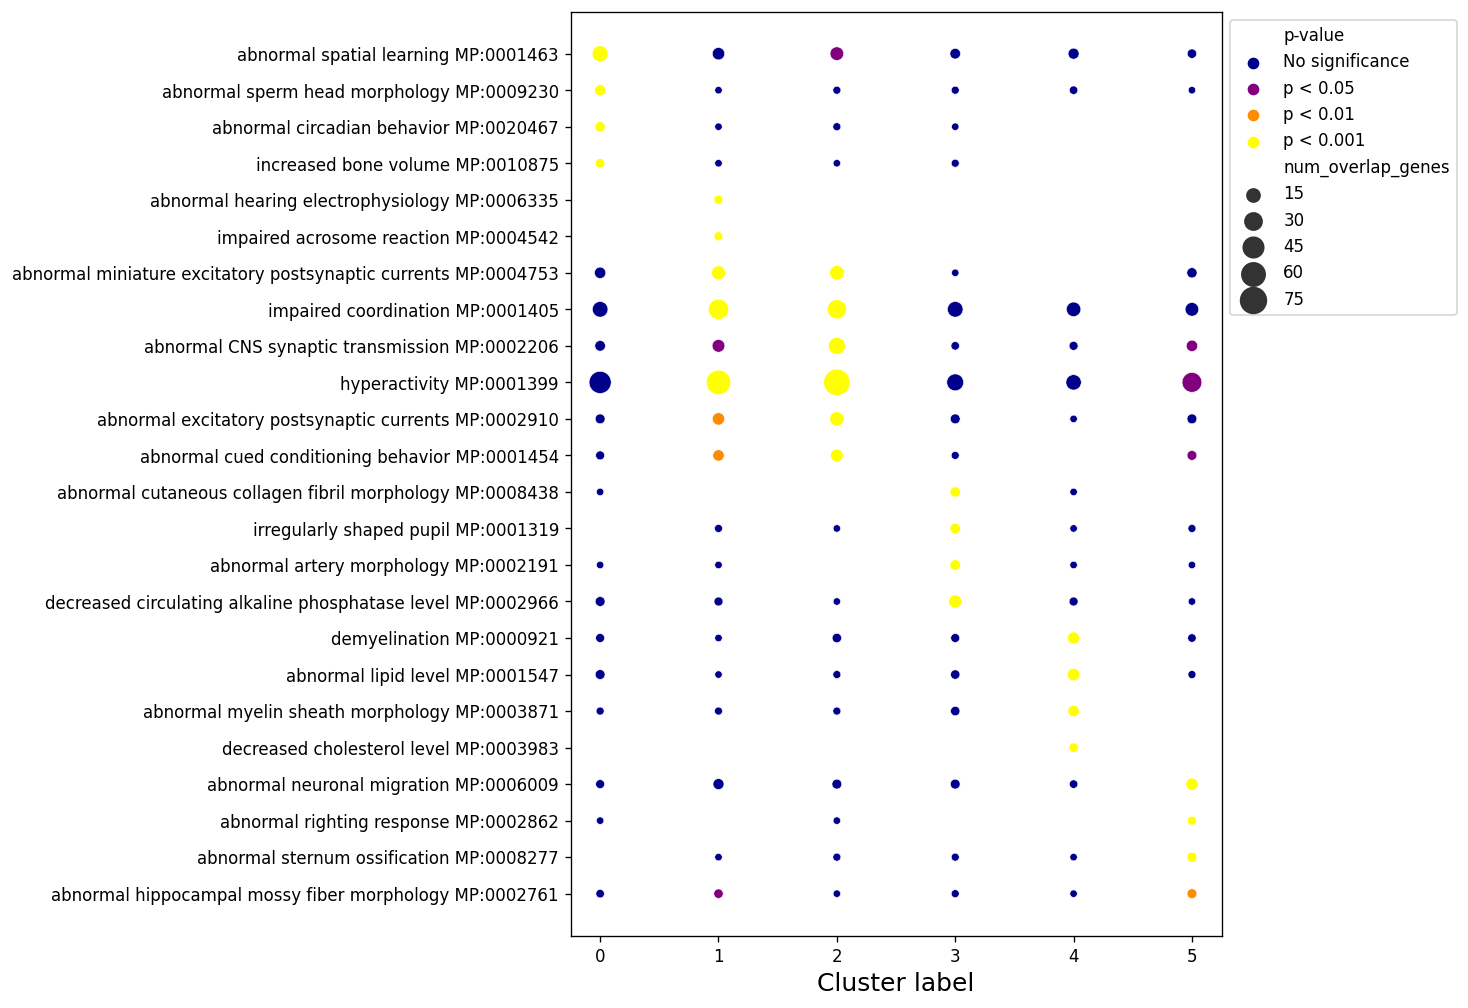

In [25]:
fig = plt.figure(figsize=(7, 10), dpi=120)

ax = sns.scatterplot(
    data=enrich_res_plot.reset_index(),
    x='cluster_label',
    y='Term',
    size='num_overlap_genes',
    sizes=(20, 250),
    hue='p-value',
    palette=color_discrete_map
)

ax.tick_params(labelsize=10)
ax.legend(fontsize=15)
ax.set_xlabel("Cluster label",fontsize=15)
ax.set_ylabel("", fontsize=10)

sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

## Reactome_2022

In [26]:
GeneCluster.enrich_geneclusters(gene_clust, 'Reactome_2022')

In [27]:
enrich_res = pd.concat([gc.enrichment_res['Reactome_2022'] for gc in gene_clust])
enrich_res = enrich_res.set_index(['Term'])
enrich_res.head()

,Rank,p-val,Z-score,Combined score,Overlapping genes,Adjusted P-value,Old p-value,Old adjusted p-value,num_overlap_genes,neg_log10(p_adj),cluster_label
Term,,,,,,,,,,,
Citric Acid (TCA) Cycle And Respiratory Electron Transport R-HSA-1428517,1,2.379001e-12,4.783712,128.032910,"[NDUFB9, COX7B, NDUFB8, NDUFB10, COX4I1, NDUFB...",2.859559e-09,0,0,38,8.543701,0
"Respiratory Electron Transport, ATP Synthesis By Chemiosmotic Coupling, Heat Production By Uncoupling Proteins R-HSA-163200",2,7.006007e-12,5.718767,146.882250,"[NDUFB9, COX7B, NDUFB8, NDUFB10, COX4I1, NDUFB...",4.210610e-09,0,0,31,8.375655,0
Respiratory Electron Transport R-HSA-611105,3,8.238600e-09,5.110061,95.120901,"[COX8A, NDUFB9, NDUFA8, COX7B, NDUFB8, COA1, N...",3.300933e-06,0,0,24,5.481363,0
Complex I Biogenesis R-HSA-6799198,4,9.104581e-06,5.165019,59.948990,"[NDUFB9, NDUFA8, NDUFB8, COA1, NDUFB10, NDUFB4...",2.735927e-03,0,0,14,2.562896,0
Voltage Gated Potassium Channels R-HSA-1296072,5,3.878826e-04,7.184436,56.432367,"[KCNG1, KCNV1, KCNC2, KCNB1, KCND3, KCNAB1, KC...",9.324697e-02,0,0,7,1.030365,0


In [28]:
terms = enrich_res[enrich_res.Rank < 5].index.unique()
terms.size

24

In [29]:
from pandas.api.types import CategoricalDtype
enrich_res_plot = enrich_res.loc[terms].copy()
cat_type = CategoricalDtype(categories=['No significance', 'p < 0.05', 'p < 0.01', 'p < 0.001'], ordered=True)
enrich_res_plot['p-value'] = enrich_res_plot['p-val'].apply(p_val_group).astype(cat_type)

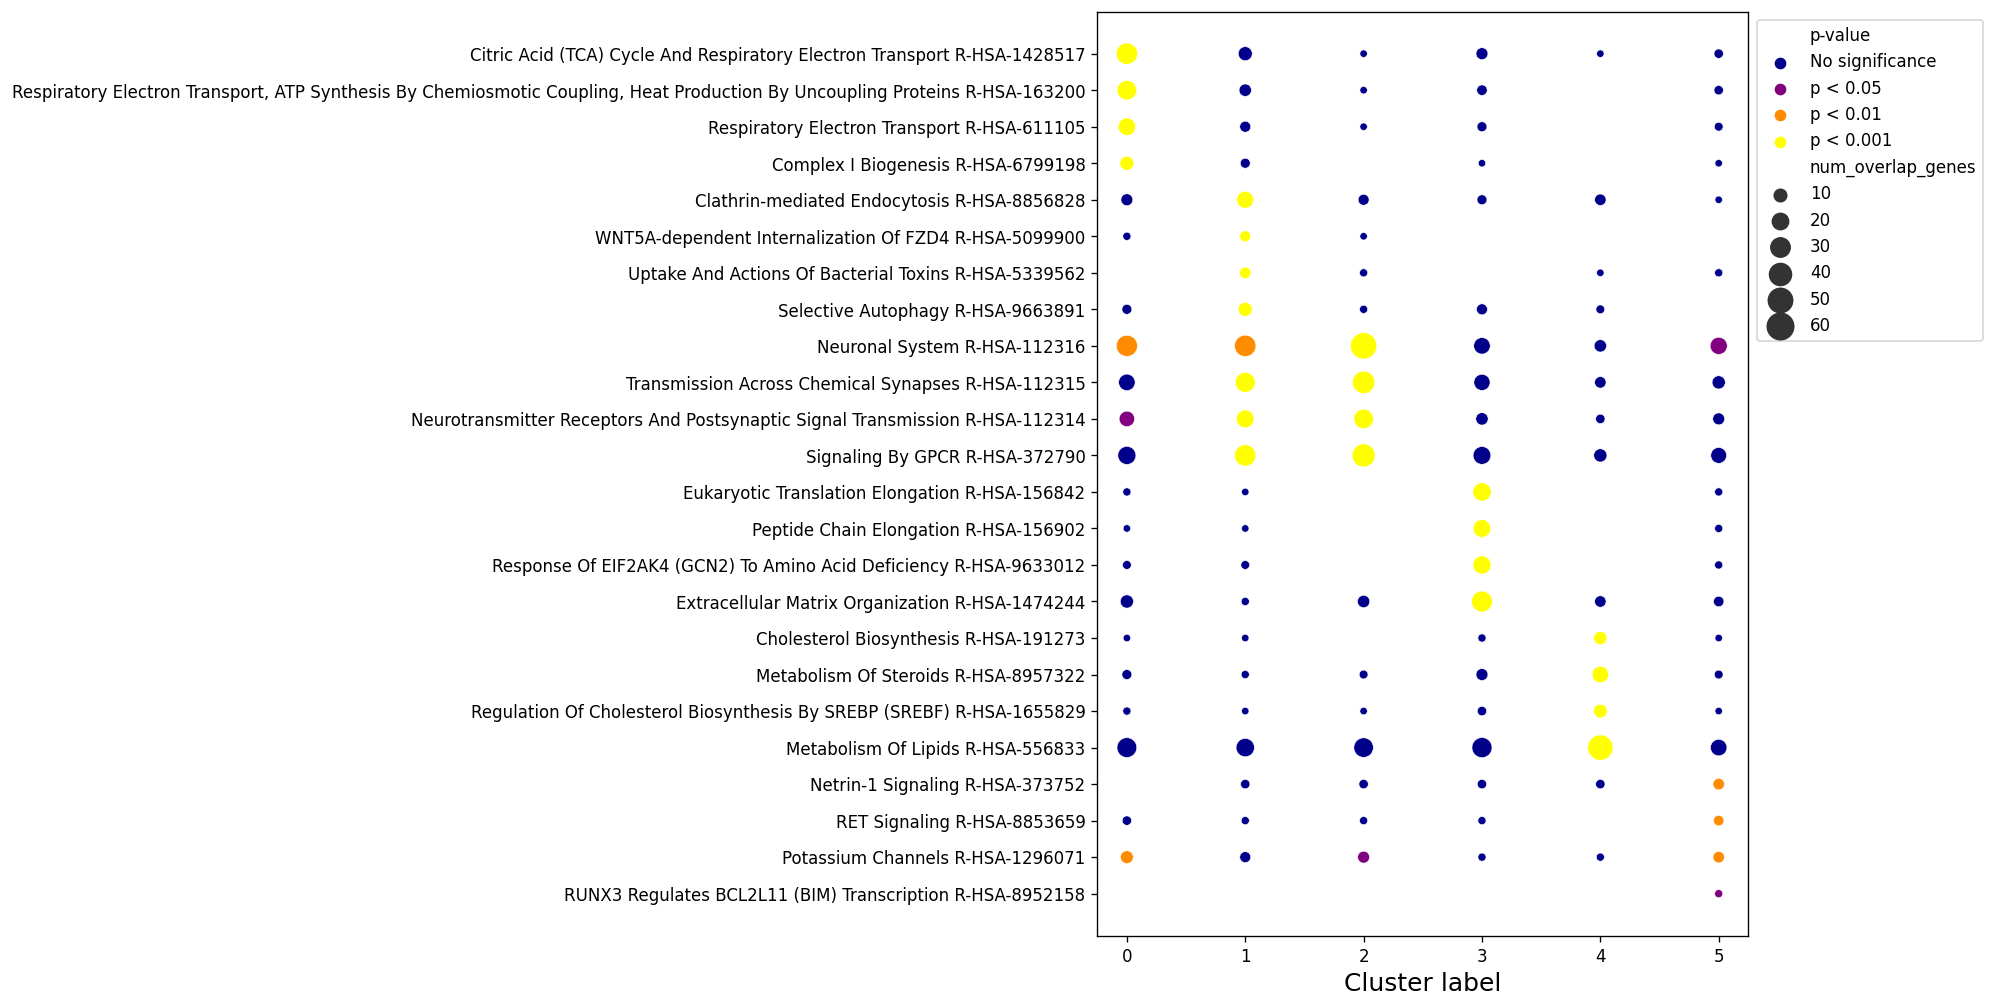

In [30]:
fig = plt.figure(figsize=(7, 10), dpi=120)

ax = sns.scatterplot(
    data=enrich_res_plot.reset_index(),
    x='cluster_label',
    y='Term',
    size='num_overlap_genes',
    sizes=(20, 250),
    hue='p-value',
    palette=color_discrete_map
)

ax.tick_params(labelsize=10)
ax.legend(fontsize=15)
ax.set_xlabel("Cluster label",fontsize=15)
ax.set_ylabel("", fontsize=10)

sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

## KEGG_2021_Human

In [31]:
GeneCluster.enrich_geneclusters(gene_clust, 'KEGG_2021_Human')

In [32]:
enrich_res = pd.concat([gc.enrichment_res['KEGG_2021_Human'] for gc in gene_clust])
enrich_res = enrich_res.set_index(['Term'])
enrich_res.head()

,Rank,p-val,Z-score,Combined score,Overlapping genes,Adjusted P-value,Old p-value,Old adjusted p-value,num_overlap_genes,neg_log10(p_adj),cluster_label
Term,,,,,,,,,,,
Oxidative phosphorylation,1,2.297347e-15,7.484632,252.284666,"[NDUFB9, COX7B, NDUFB8, NDUFB10, COX4I1, NDUFB...",6.340678e-13,0,0,34,12.197864,0
Diabetic cardiomyopathy,2,2.147866e-11,4.250368,104.405879,"[NDUFB9, COX7B, NDUFB8, NDUFB10, COX4I1, NDUFB...",2.964055e-09,0,0,39,8.528114,0
Parkinson disease,3,7.877331e-10,3.441741,72.145307,"[NDUFB9, COX7B, NDUFB8, NDUFB10, COX4I1, NDUFB...",7.247144e-08,0,0,42,7.139833,0
Non-alcoholic fatty liver disease,4,2.087008e-08,3.993123,70.618173,"[NDUFB9, COX7B, GSK3A, NDUFB8, NDUFB10, COX4I1...",1.440036e-06,0,0,29,5.841627,0
Thermogenesis,5,1.964391e-07,3.059169,47.242478,"[NDUFB9, COX7B, NDUFB8, NDUFB10, COX4I1, NDUFB...",1.084344e-05,0,0,35,4.964833,0


In [33]:
terms = enrich_res[enrich_res.Rank < 5].index.unique()
terms.size

22

In [34]:
from pandas.api.types import CategoricalDtype
enrich_res_plot = enrich_res.loc[terms].copy()
cat_type = CategoricalDtype(categories=['No significance', 'p < 0.05', 'p < 0.01', 'p < 0.001'], ordered=True)
enrich_res_plot['p-value'] = enrich_res_plot['p-val'].apply(p_val_group).astype(cat_type)

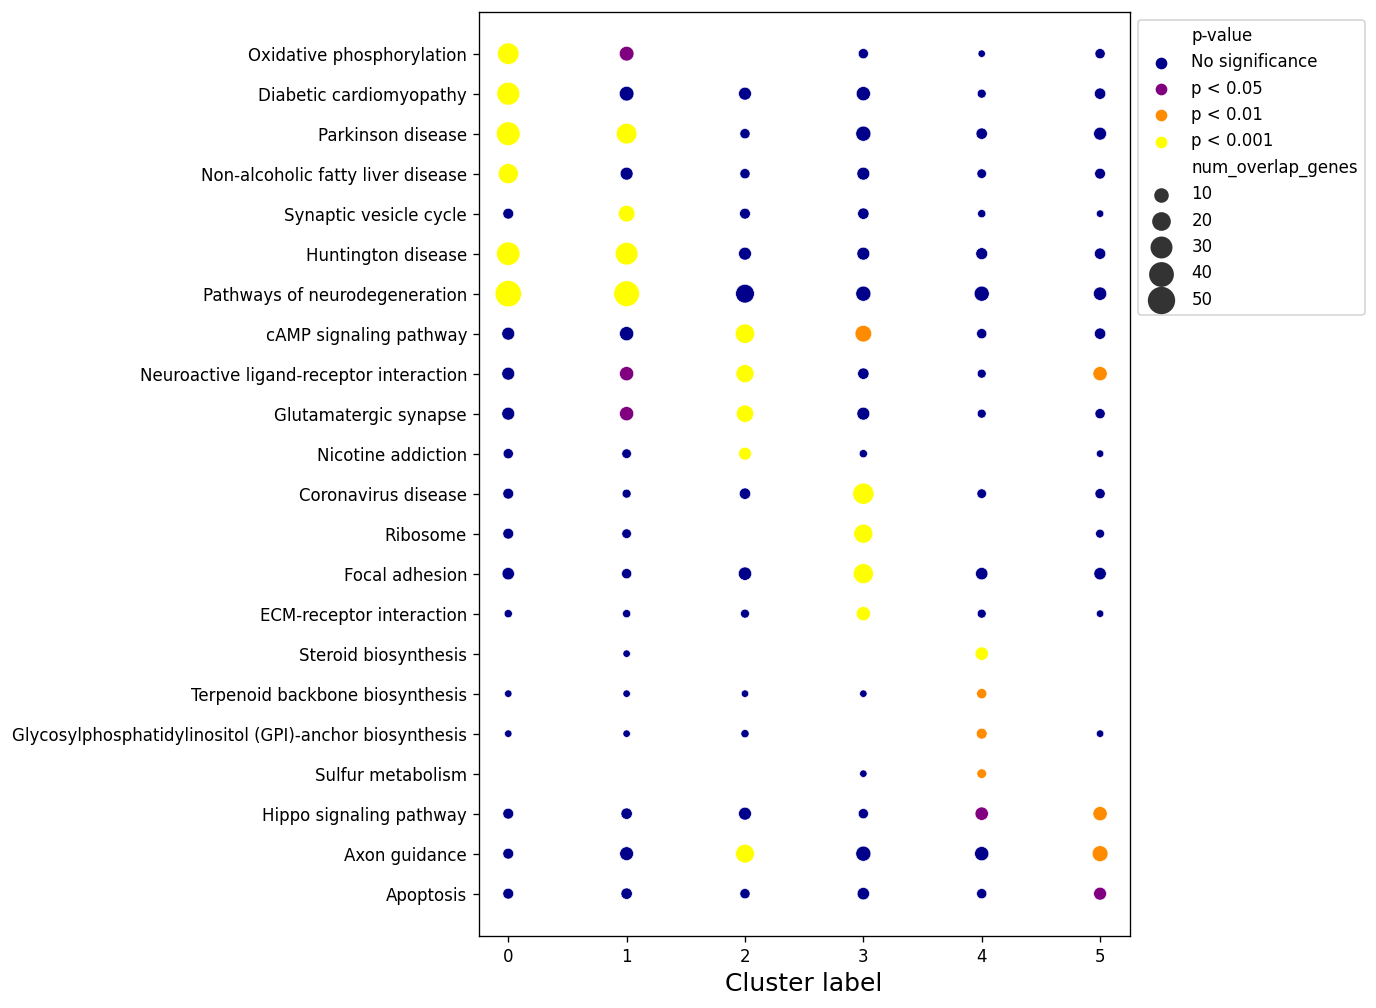

In [35]:
fig = plt.figure(figsize=(7, 10), dpi=120)

ax = sns.scatterplot(
    data=enrich_res_plot.reset_index(),
    x='cluster_label',
    y='Term',
    size='num_overlap_genes',
    sizes=(20, 250),
    hue='p-value',
    palette=color_discrete_map
)

ax.tick_params(labelsize=10)
ax.legend(fontsize=15)
ax.set_xlabel("Cluster label",fontsize=15)
ax.set_ylabel("", fontsize=10)

sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

# GSA (7 clusters)

In [36]:
n_clusters = 7
cluster_spectr = pd.read_csv(de_dir_path + f'cluster_spectr_anova_mean_{n_clusters}.csv', index_col=0)
cluster_spectr.columns = ['label']
cluster_spectr.head()

,label
A1BG,0
IMMP1L,0
ING4,0
IP6K2,0
IRS2,0


In [37]:
import time
gene_clust = list()

for label in tqdm(range(n_clusters)):
    genes = cluster_spectr[cluster_spectr.label == label].index.tolist()
    descr = f'Genes for spectral clustering ({n_clusters} clusters) of human-specific genes. Cluster label: {label}'
    gene_clust.append(GeneCluster(genes, descr, label, background_genes))
    time.sleep(1)

  0%|          | 0/7 [00:00<?, ?it/s]

## GO_Biological_Process_2021

In [38]:
GeneCluster.enrich_geneclusters(gene_clust, 'GO_Biological_Process_2021')

In [39]:
enrich_res = pd.concat([gc.enrichment_res['GO_Biological_Process_2021'] for gc in gene_clust])
enrich_res = enrich_res.set_index(['Term'])
enrich_res.head()

,Rank,p-val,Z-score,Combined score,Overlapping genes,Adjusted P-value,Old p-value,Old adjusted p-value,num_overlap_genes,neg_log10(p_adj),cluster_label
Term,,,,,,,,,,,
axon guidance (GO:0007411),1,1.941401e-07,3.798762,58.708667,"[CYFIP1, DRAXIN, PLXND1, SEMA3C, PTPRO, NTN4, ...",0.000466,0,0,25,3.331493,0
axonogenesis (GO:0007409),2,2.401254e-05,2.857254,30.392425,"[SEMA6B, CYFIP1, EPHA4, DRAXIN, AUTS2, SEMA3C,...",0.028827,0,0,24,1.540200,0
positive regulation of plasma membrane bounded cell projection assembly (GO:0120034),3,1.467903e-04,4.429448,39.096547,"[EPS8, CYFIP1, MIEN1, AUTS2, TGFB3, CEP120, CD...",0.117481,0,0,11,0.930032,0
cell junction assembly (GO:0034329),4,5.860809e-04,3.673458,27.338065,"[KIRREL3, SDK1, PLXND1, FBLIM1, FSCN1, DCHS1, ...",0.351795,0,0,11,0.453710,0
negative regulation of cell motility (GO:2000146),5,7.674668e-04,3.539059,25.383603,"[EPHA4, FRMD5, TMEFF2, MCTP1, RAP2B, LIMCH1, S...",0.368538,0,0,11,0.433518,0


In [40]:
terms = enrich_res[enrich_res.Rank < 5].index.unique()
terms.size

26

In [41]:
from pandas.api.types import CategoricalDtype
enrich_res_plot = enrich_res.loc[terms].copy()
cat_type = CategoricalDtype(categories=['No significance', 'p < 0.05', 'p < 0.01', 'p < 0.001'], ordered=True)
enrich_res_plot['p-value'] = enrich_res_plot['p-val'].apply(p_val_group).astype(cat_type)

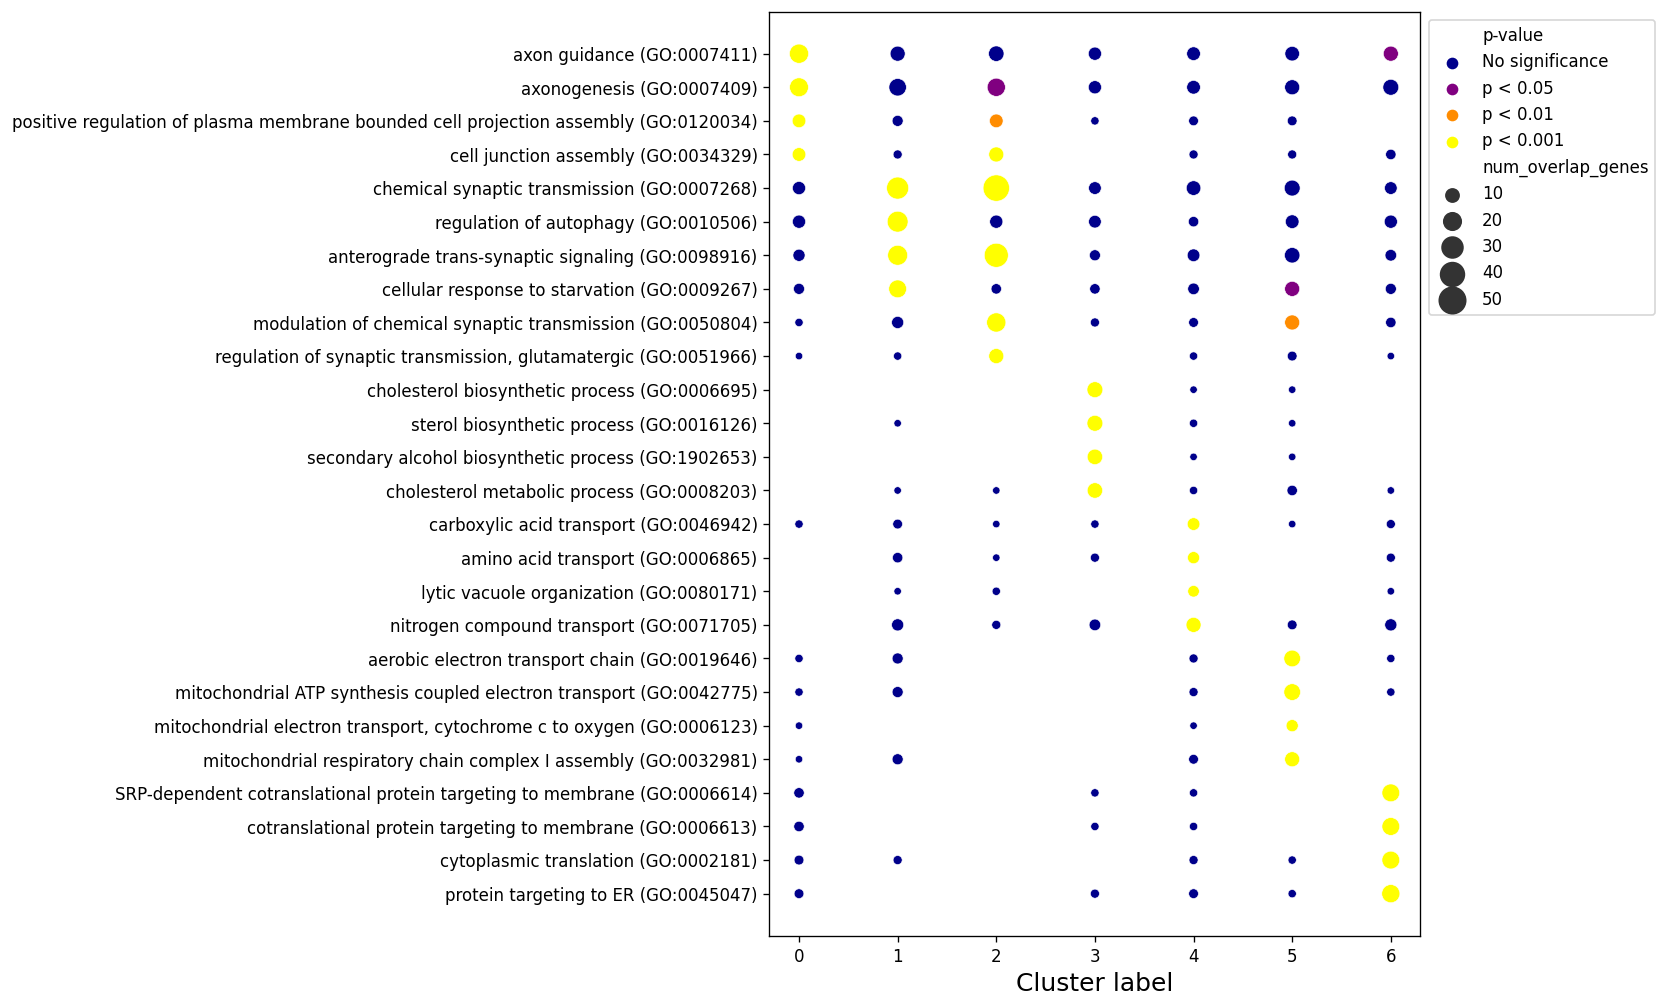

In [42]:
fig = plt.figure(figsize=(7, 10), dpi=120)

ax = sns.scatterplot(
    data=enrich_res_plot.reset_index(),
    x='cluster_label',
    y='Term',
    size='num_overlap_genes',
    sizes=(20, 250),
    hue='p-value',
    palette=color_discrete_map
)

ax.tick_params(labelsize=10)
ax.legend(fontsize=15)
ax.set_xlabel("Cluster label",fontsize=15)
ax.set_ylabel("", fontsize=10)

sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

## Azimuth Cell Types 2021


In [43]:
GeneCluster.enrich_geneclusters(gene_clust, 'Azimuth_Cell_Types_2021')

In [44]:
enrich_res = pd.concat([gc.enrichment_res['Azimuth_Cell_Types_2021'] for gc in gene_clust])
enrich_res = enrich_res.set_index(['Term'])
enrich_res.head()

,Rank,p-val,Z-score,Combined score,Overlapping genes,Adjusted P-value,Old p-value,Old adjusted p-value,num_overlap_genes,neg_log10(p_adj),cluster_label
Term,,,,,,,,,,,
"Layer 2-3 Glutamatergic Neuron, Intratelencephalon-Projecting CL0000679",1,0.000004,26.429150,326.371742,"[CUX2, DAB1, LRRTM4, ENC1, MEIS2, CBLN2]",0.000529,0,0,6,3.276713,0
VIP+ SOX11+ Layer 2-5 GABAergic Neuron CL0000617,2,0.001466,26.275654,171.457546,"[PENK, SOX11, VIP]",0.082368,0,0,3,1.084239,0
Vip+ GABAergic Neuron 1 CL0000617,3,0.002814,17.515091,102.871271,"[ASIC4, KLF12, VIP]",0.082368,0,0,3,1.084239,0
VIP+ ZIM2-AS1+ Layer 3-6 GABAergic Neuron CL0000617,4,0.002943,inf,inf,"[PENK, VIP]",0.082368,0,0,2,1.084239,0
VIP+ WNT4+ Layer 1-2 GABAergic Neuron CL0000617,5,0.004726,13.134809,70.332483,"[CCK, VIP, ROBO1]",0.082368,0,0,3,1.084239,0


In [45]:
terms = enrich_res[enrich_res.Rank < 5].index.unique()
terms.size

27

In [46]:
from pandas.api.types import CategoricalDtype
enrich_res_plot = enrich_res.loc[terms].copy()
cat_type = CategoricalDtype(categories=['No significance', 'p < 0.05', 'p < 0.01', 'p < 0.001'], ordered=True)
enrich_res_plot['p-value'] = enrich_res_plot['p-val'].apply(p_val_group).astype(cat_type)

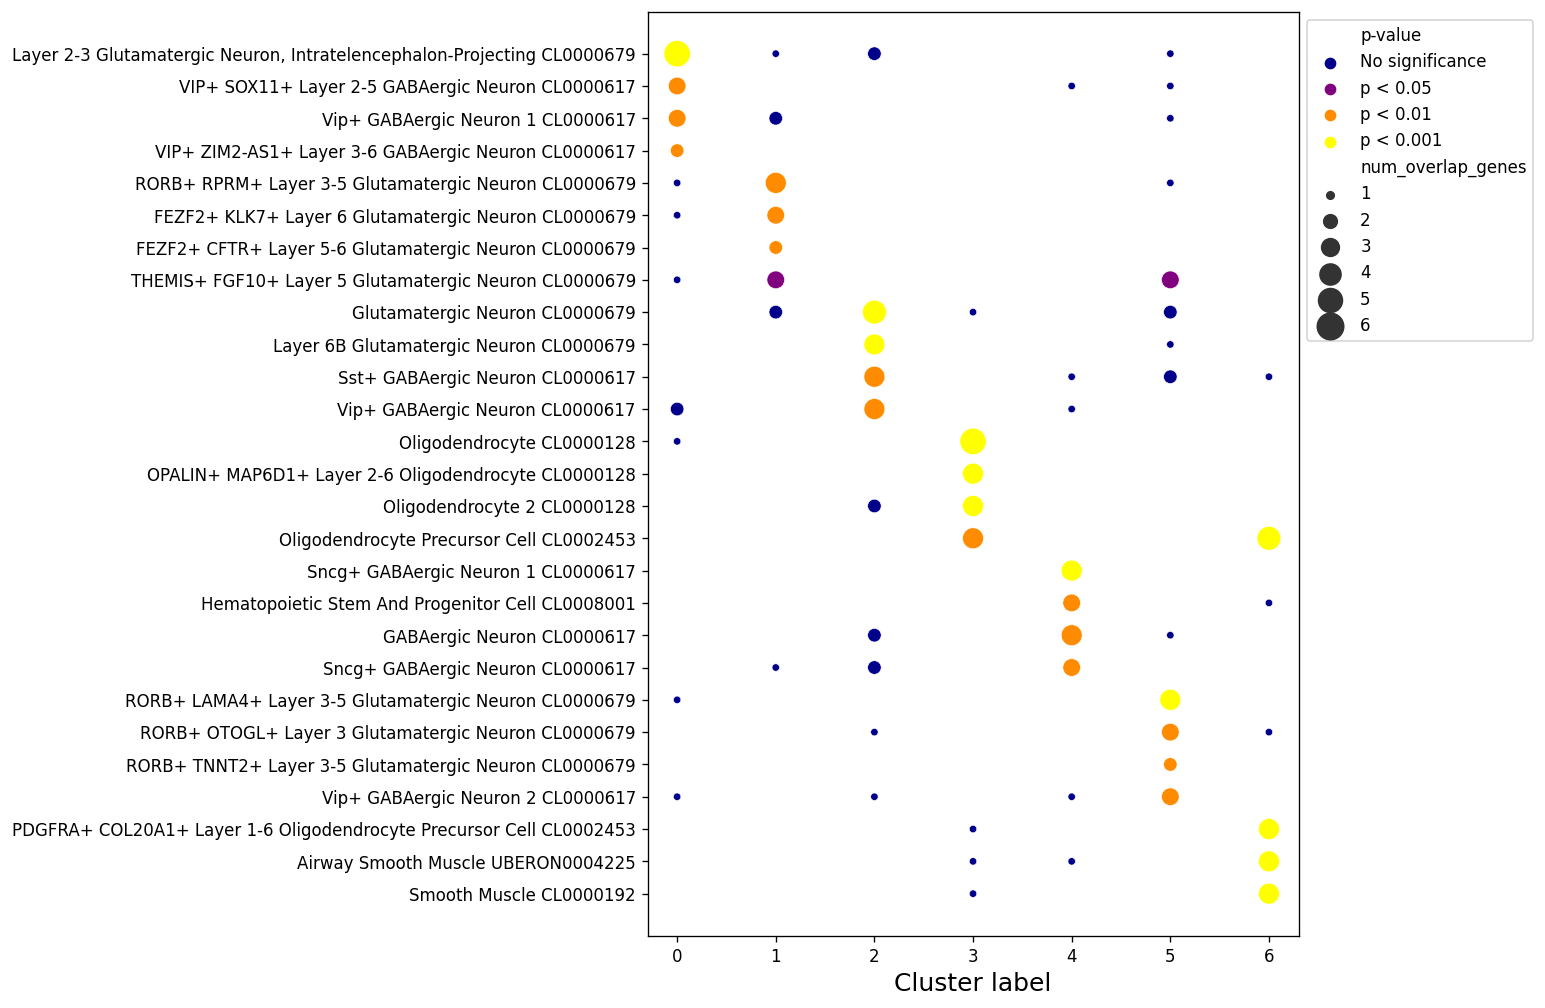

In [47]:
fig = plt.figure(figsize=(7, 10), dpi=120)

ax = sns.scatterplot(
    data=enrich_res_plot.reset_index(),
    x='cluster_label',
    y='Term',
    size='num_overlap_genes',
    sizes=(20, 250),
    hue='p-value',
    palette=color_discrete_map
)

ax.tick_params(labelsize=10)
ax.legend(fontsize=15)
ax.set_xlabel("Cluster label",fontsize=15)
ax.set_ylabel("", fontsize=10)

sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

## MGI_Mammalian_Phenotype_Level_4_2021

In [48]:
GeneCluster.enrich_geneclusters(gene_clust, 'MGI_Mammalian_Phenotype_Level_4_2021')

In [49]:
enrich_res = pd.concat([gc.enrichment_res['MGI_Mammalian_Phenotype_Level_4_2021'] for gc in gene_clust])
enrich_res = enrich_res.set_index(['Term'])
enrich_res.head()

,Rank,p-val,Z-score,Combined score,Overlapping genes,Adjusted P-value,Old p-value,Old adjusted p-value,num_overlap_genes,neg_log10(p_adj),cluster_label
Term,,,,,,,,,,,
abnormal neuronal migration MP:0006009,1,0.000142,4.093317,36.264274,"[TOP2B, TRIO, TUBA1A, DAB1, FLRT2, AUTS2, PLXN...",0.282238,0,0,12,0.549385,0
abnormal sternum ossification MP:0008277,2,0.000501,7.542510,57.308163,"[SMPD3, SOX11, DCHS1, FAT4, MLLT3, RNF2]",0.334269,0,0,6,0.475904,0
abnormal righting response MP:0002862,3,0.000505,17.548387,133.219940,"[GABRB3, AADAT, NPY1R, SHANK3]",0.334269,0,0,4,0.475904,0
abnormal telencephalon development MP:0000934,4,0.000732,5.605938,40.474000,"[TOP2B, PGAP1, TUBA1A, DAB1, CAMSAP1, NEUROG2,...",0.345561,0,0,7,0.461475,0
abnormal anterior commissure pars posterior morphology MP:0010860,5,0.000870,14.037097,98.926841,"[EFNB2, EPHA4, FSCN1, PLXNA4]",0.345561,0,0,4,0.461475,0


In [50]:
terms = enrich_res[enrich_res.Rank < 5].index.unique()
terms.size

27

In [51]:
from pandas.api.types import CategoricalDtype
enrich_res_plot = enrich_res.loc[terms].copy()
cat_type = CategoricalDtype(categories=['No significance', 'p < 0.05', 'p < 0.01', 'p < 0.001'], ordered=True)
enrich_res_plot['p-value'] = enrich_res_plot['p-val'].apply(p_val_group).astype(cat_type)

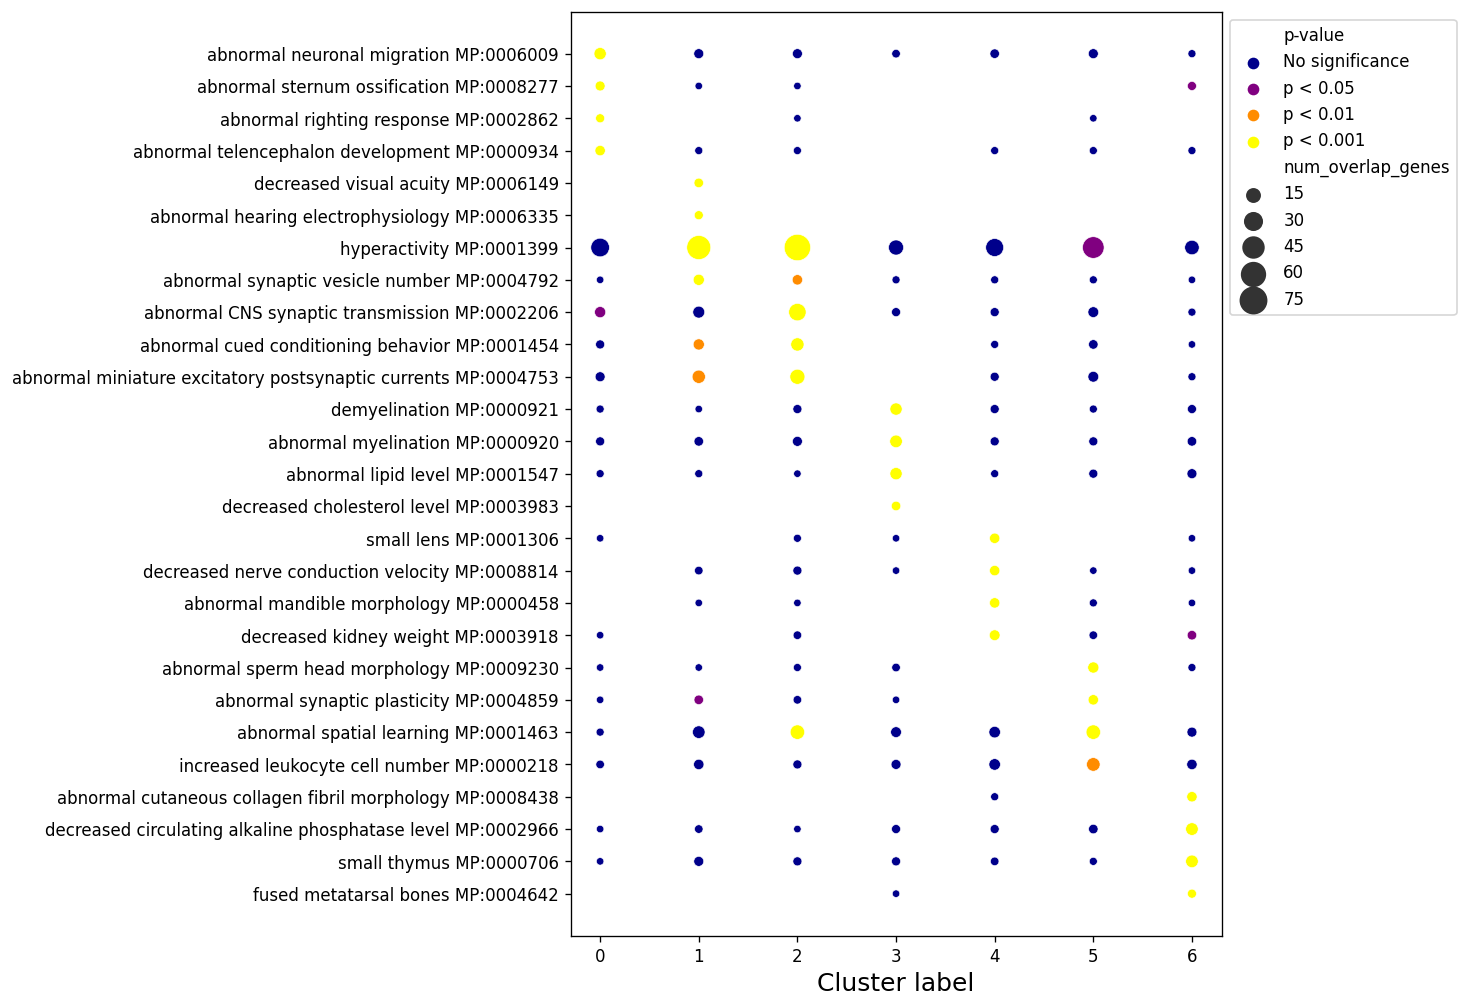

In [52]:
fig = plt.figure(figsize=(7, 10), dpi=120)

ax = sns.scatterplot(
    data=enrich_res_plot.reset_index(),
    x='cluster_label',
    y='Term',
    size='num_overlap_genes',
    sizes=(20, 250),
    hue='p-value',
    palette=color_discrete_map
)

ax.tick_params(labelsize=10)
ax.legend(fontsize=15)
ax.set_xlabel("Cluster label",fontsize=15)
ax.set_ylabel("", fontsize=10)

sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

## Reactome_2022

In [53]:
GeneCluster.enrich_geneclusters(gene_clust, 'Reactome_2022')

In [54]:
enrich_res = pd.concat([gc.enrichment_res['Reactome_2022'] for gc in gene_clust])
enrich_res = enrich_res.set_index(['Term'])
enrich_res.head()

,Rank,p-val,Z-score,Combined score,Overlapping genes,Adjusted P-value,Old p-value,Old adjusted p-value,num_overlap_genes,neg_log10(p_adj),cluster_label
Term,,,,,,,,,,,
Netrin-1 Signaling R-HSA-373752,1,0.000823,4.703523,33.405387,"[MAPK8, TRIO, SIAH1, NTN4, UNC5D, RGMB, NEO1, ...",0.694031,0,0,8,0.158621,0
RUNX3 Regulates BCL2L11 (BIM) Transcription R-HSA-8952158,2,0.008510,34.967871,166.673031,"[SMAD4, FOXO3]",0.999922,0,0,2,0.000034,0
TNFR1-mediated Ceramide Production R-HSA-5626978,3,0.008510,34.967871,166.673031,"[SMPD3, RACK1]",0.999922,0,0,2,0.000034,0
Voltage Gated Potassium Channels R-HSA-1296072,4,0.011611,5.393921,24.034121,"[KCNH2, KCNV1, KCNH5, KCND2]",0.999922,0,0,4,0.000034,0
Developmental Biology R-HSA-1266738,5,0.012765,1.490729,6.501145,"[TRIO, PLXND1, NTN4, ADAM22, IRS2, PIK3R2, FOX...",0.999922,0,0,43,0.000034,0


In [55]:
terms = enrich_res[enrich_res.Rank < 5].index.unique()
terms.size

27

In [56]:
from pandas.api.types import CategoricalDtype
enrich_res_plot = enrich_res.loc[terms].copy()
cat_type = CategoricalDtype(categories=['No significance', 'p < 0.05', 'p < 0.01', 'p < 0.001'], ordered=True)
enrich_res_plot['p-value'] = enrich_res_plot['p-val'].apply(p_val_group).astype(cat_type)

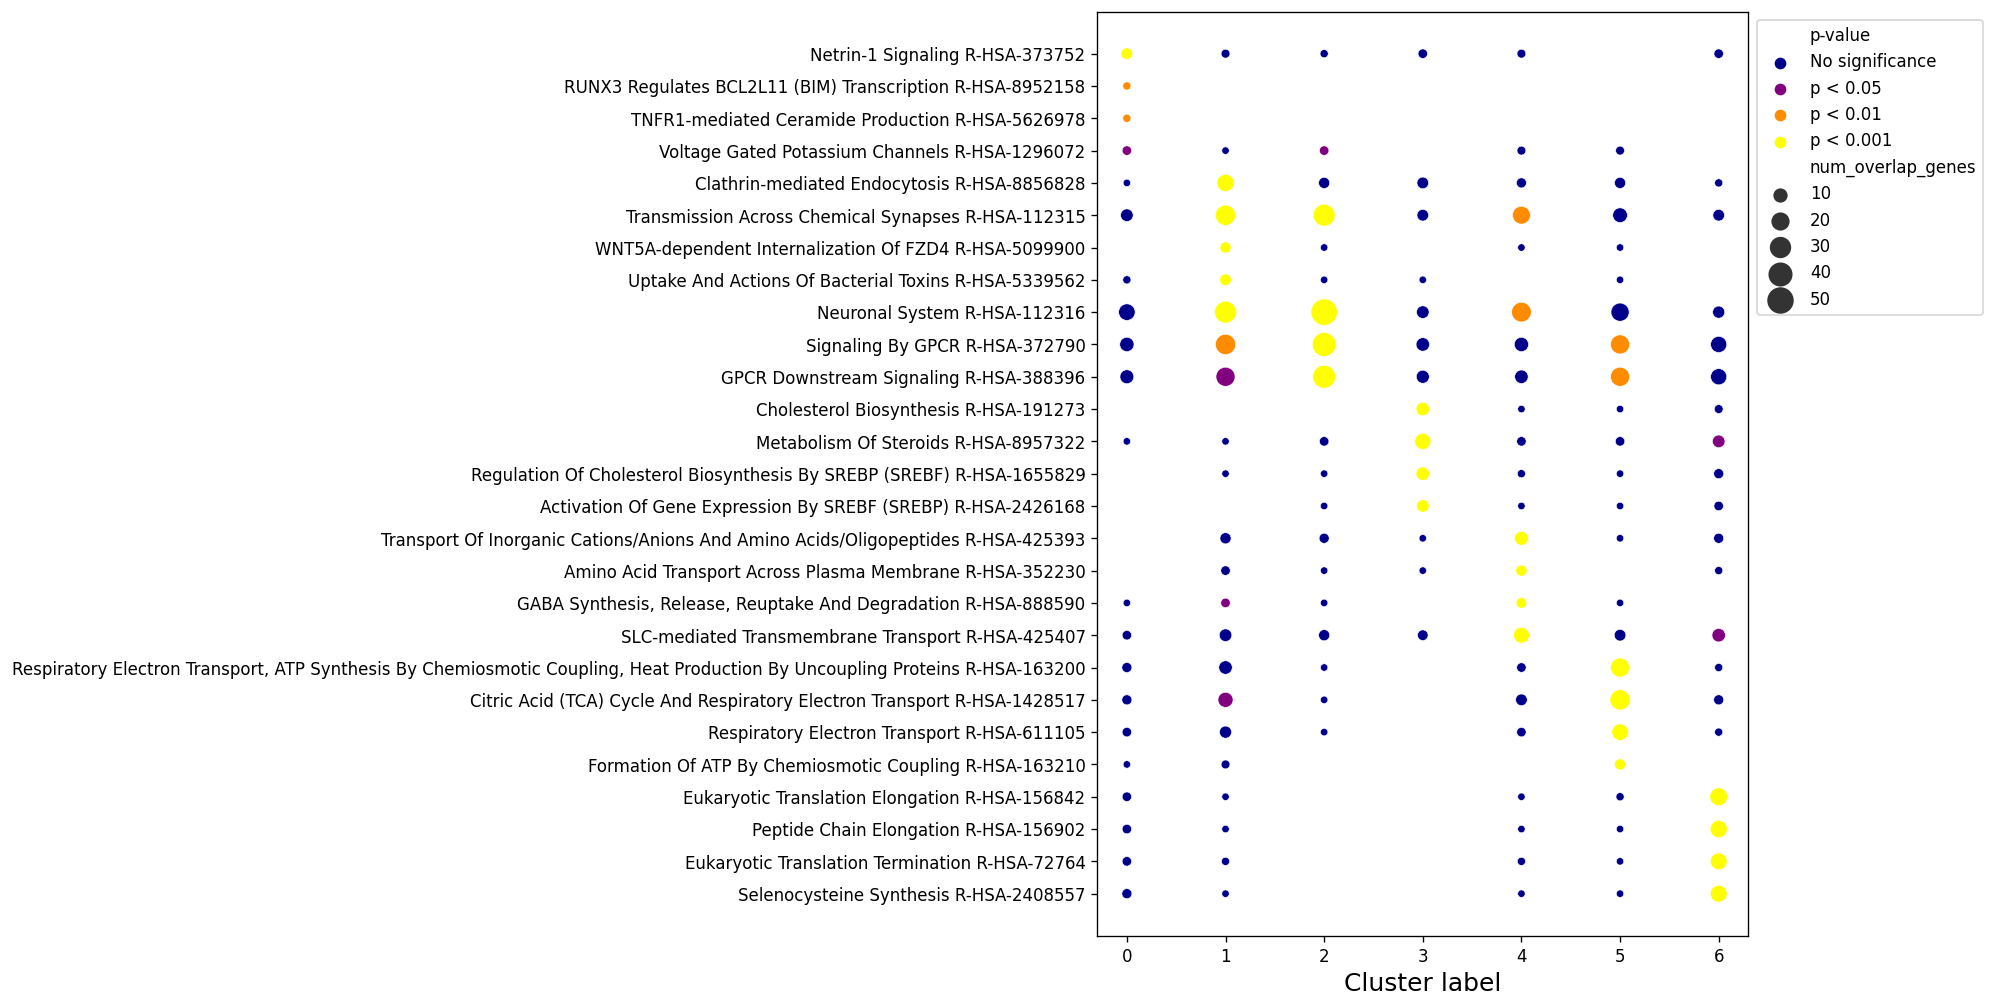

In [57]:
fig = plt.figure(figsize=(7, 10), dpi=120)

ax = sns.scatterplot(
    data=enrich_res_plot.reset_index(),
    x='cluster_label',
    y='Term',
    size='num_overlap_genes',
    sizes=(20, 250),
    hue='p-value',
    palette=color_discrete_map
)

ax.tick_params(labelsize=10)
ax.legend(fontsize=15)
ax.set_xlabel("Cluster label",fontsize=15)
ax.set_ylabel("", fontsize=10)

sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

## KEGG_2021_Human

In [58]:
GeneCluster.enrich_geneclusters(gene_clust, 'KEGG_2021_Human')

In [59]:
enrich_res = pd.concat([gc.enrichment_res['KEGG_2021_Human'] for gc in gene_clust])
enrich_res = enrich_res.set_index(['Term'])
enrich_res.head()

,Rank,p-val,Z-score,Combined score,Overlapping genes,Adjusted P-value,Old p-value,Old adjusted p-value,num_overlap_genes,neg_log10(p_adj),cluster_label
Term,,,,,,,,,,,
Axon guidance,1,0.001163,2.518910,17.018742,"[SEMA6B, EPHA4, SEMA3C, SEMA4C, NTN4, PIK3R2, ...",0.271077,0,0,17,0.566908,0
Hippo signaling pathway,2,0.014030,2.414034,10.299674,"[PPP1CC, SMAD4, RASSF2, DLG2, TGFB3, SNAI2, DC...",0.986572,0,0,10,0.005871,0
Neuroactive ligand-receptor interaction,3,0.022014,2.229140,8.506562,"[GABRB3, NPB, GLRA3, PENK, NPY1R, CRH, LPAR2, ...",0.986572,0,0,10,0.005871,0
Apoptosis,4,0.051693,1.976884,5.856369,"[MAPK8, TUBA1A, ITPR1, DAB2IP, CASP2, PIK3R2, ...",0.986572,0,0,9,0.005871,0
Various types of N-glycan biosynthesis,5,0.077061,2.692928,6.902392,"[CHST8, MGAT4C, MAN1C1, ST3GAL3]",0.986572,0,0,4,0.005871,0


In [60]:
terms = enrich_res[enrich_res.Rank < 5].index.unique()
terms.size

25

In [61]:
from pandas.api.types import CategoricalDtype
enrich_res_plot = enrich_res.loc[terms].copy()
cat_type = CategoricalDtype(categories=['No significance', 'p < 0.05', 'p < 0.01', 'p < 0.001'], ordered=True)
enrich_res_plot['p-value'] = enrich_res_plot['p-val'].apply(p_val_group).astype(cat_type)

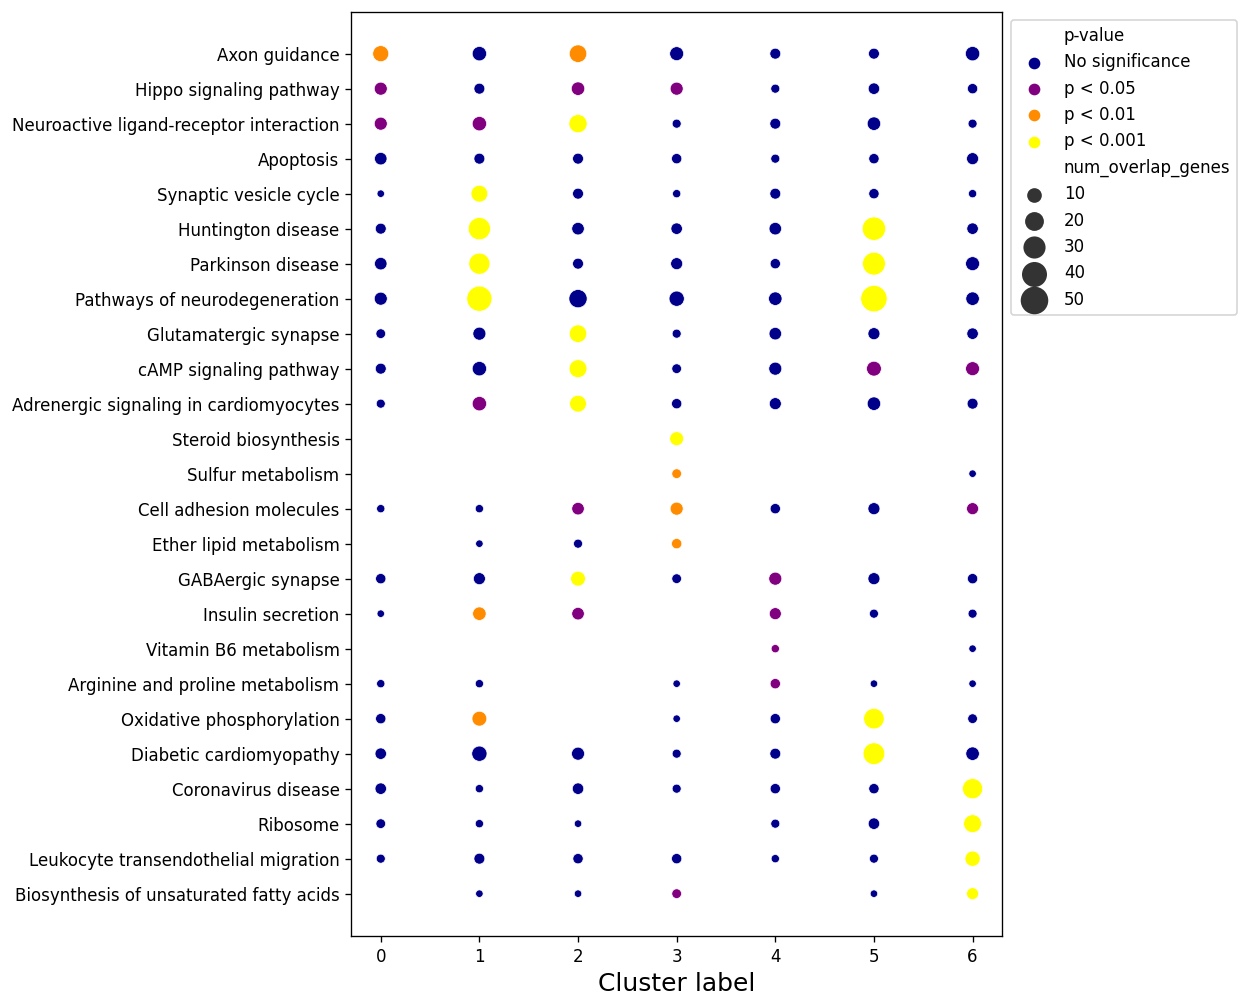

In [62]:
fig = plt.figure(figsize=(7, 10), dpi=120)

ax = sns.scatterplot(
    data=enrich_res_plot.reset_index(),
    x='cluster_label',
    y='Term',
    size='num_overlap_genes',
    sizes=(20, 250),
    hue='p-value',
    palette=color_discrete_map
)

ax.tick_params(labelsize=10)
ax.legend(fontsize=15)
ax.set_xlabel("Cluster label",fontsize=15)
ax.set_ylabel("", fontsize=10)

sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))